# Instability of Parameter Estimates | How estimates can lie and ways to deal with that.

To actually understand what is going on you need to determine how good your estimate is by looking at its stability/standard error/confidence intervals.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set()

## Instability of estimates

We can quantify the uncertainty in our estimate by looking at how the parameter changes as we look at different subsets of the data. 

### Example: mean and standard deviation

First, let's take a look at some samples from a normal distribution. We know that the mean of the distribution is 0 and the standard deviation is 1; but if we measure the parameters from our observations, we will get only approximately 0 and approximately 1. We can see how these estimates change as we take more and more samples:

0.44806111169875623
-0.10384651739409384
-0.0024229041215306567
0.006837994588647575


/Users/adhiman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


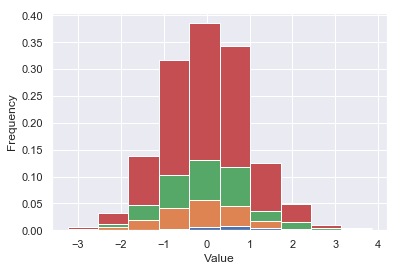

In [2]:
# Set a seed so we can play with the data without generating new random numbers every time
np.random.seed(42)

normal = np.random.randn(500)
print(np.mean(normal[:10]))
print(np.mean(normal[:100]))
print(np.mean(normal[:250]))
print(np.mean(normal))

# Plot a stacked histogram of the data
plt.hist([normal[:10], normal[10:100], normal[100:250], normal], normed=1, histtype='bar', stacked=True);
plt.ylabel('Frequency')
plt.xlabel('Value');

In [3]:
print(np.std(normal[:10]))
print(np.std(normal[:100]))
print(np.std(normal[:250]))
print(np.std(normal))

0.6859059302944951
0.9036161766446296
0.9641196524603245
0.9802715029966268


### Example: Non-Normal Underlying Distribution

mean: 0.06559305293620218
standard deviation: 5.130869180943395


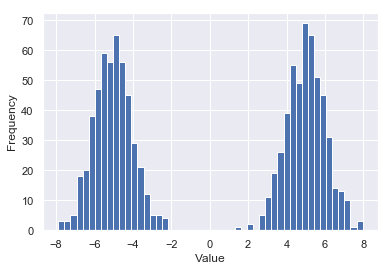

In [4]:
#Generate some data from a bi-modal distribution
def bimodal(n):
    X = np.zeros((n))
    for i in range(n):
        if np.random.binomial(1, 0.5) == 0:
            X[i] = np.random.normal(-5, 1)
        else:
            X[i] =  np.random.normal(5, 1)
    return X
            
X = bimodal(1000)

#Let's see how it looks
plt.hist(X, bins=50)
plt.ylabel('Frequency')
plt.xlabel('Value')
print('mean:', np.mean(X))
print('standard deviation:', np.std(X))

Sure enough, the mean is increidbly non-informative about what is going on in the data. 

This is what the distribution should look like if our hypothesis that it is normally distributed is correct.

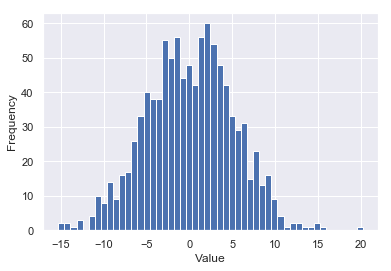

In [5]:
mu = np.mean(X)
sigma = np.std(X)

N = np.random.normal(mu, sigma, 1000)

plt.hist(N, bins=50)
plt.ylabel('Frequency')
plt.xlabel('Value');

We'll test our data using the Jarque-Bera test to see if it's normal. A significant p-value indicates non-normality.

In [6]:
from statsmodels.stats.stattools import jarque_bera

_, JBpv, _, _ = jarque_bera(X)
print(JBpv)

9.316009996735539e-32


Sure enough the value is < 0.05 and we say that X is not normal. This saves us from accidentally making horrible predictions.

### Example: Sharpe ratio

One statistic often used to describe the performance of assets and portfolios is the Sharpe ratio, which measures the additional return per unit additional risk achieved by a portfolio, relative to a risk-free source of return 

As with mean and standard deviation, we can compute a rolling Sharpe ratio to see how our estimate changes through time.

In [33]:
from nsepy import get_history
from datetime import date, datetime, timedelta
import fix_yahoo_finance as yf
yf.pdr_override()

def sharpe_ratio(asset, riskfree):
    return np.mean(asset - riskfree)/np.std(asset - riskfree)

start = date(2015,1,1)
end = date.today()

# Use an ETF that tracks 3-month T-bills as our risk-free rate of return
treasury_ret = yf.download('^NSEI', start=start, end=end)['Adj Close'].pct_change()[1:]
pricing = yf.download('YESBANK.NS', start=start, end=end)['Adj Close']
returns = pricing.pct_change()[1:] # Get the returns on the asset

# Compute the running Sharpe ratio
running_sharpe = [sharpe_ratio(returns[i-90:i], treasury_ret[i-90:i]) for i in range(90, len(returns))]

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


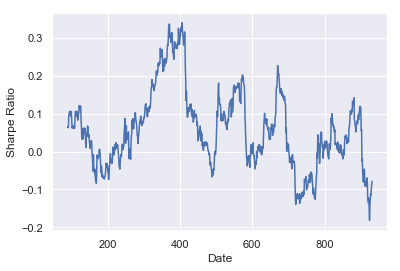

In [35]:
# Plot running Sharpe ratio up to 100 days before the end of the data set
_, ax1 = plt.subplots()
ax1.plot(range(90, len(returns)-100), running_sharpe[:-100]);
ticks = ax1.get_xticks()
# ax1.set_xticklabels([pricing.index[i].date() for i in ticks[:-1]]) # Label x-axis with dates
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio');

The Sharpe ratio looks rather volatile, and it's clear that just reporting it as a single value will not be very helpful for predicting future values. Instead, we can compute the mean and standard deviation of the data above, and then see if it helps us predict the Sharpe ratio for the next 100 days.

Mean of running Sharpe ratio: 0.05840181405024588
std of running Sharpe ratio: 0.10280418571916258


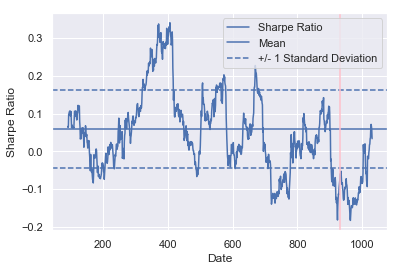

In [36]:
# Compute the mean and std of the running Sharpe ratios up to 100 days before the end
mean_rs = np.mean(running_sharpe[:-100])
std_rs = np.std(running_sharpe[:-100])

# Plot running Sharpe ratio
_, ax2 = plt.subplots()
#ax2.set_xticklabels([pricing.index[i].date() for i in ticks[:-1]]) # Label x-axis with dates
ax2.plot(range(90, len(returns)), running_sharpe)

# Plot its mean and the +/- 1 standard deviation lines
ax2.axhline(mean_rs)
ax2.axhline(mean_rs + std_rs, linestyle='--')
ax2.axhline(mean_rs - std_rs, linestyle='--')

# Indicate where we computed the mean and standard deviations
# Everything after this is 'out of sample' which we are comparing with the estimated mean and std
ax2.axvline(len(returns) - 100, color='pink');
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.legend(['Sharpe Ratio', 'Mean', '+/- 1 Standard Deviation'])

print('Mean of running Sharpe ratio:', mean_rs)
print('std of running Sharpe ratio:', std_rs)

### Example: Moving Average

Mean of rolling mean: 240.29351968308657
std of rolling mean: 77.46134117412667


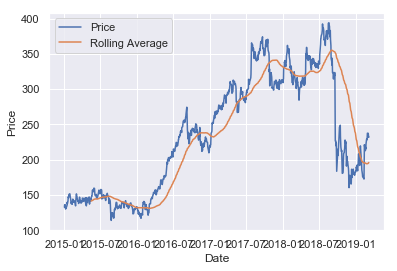

In [39]:
# Compute the rolling mean for each day
mu = pricing.rolling(90).mean()

# Plot pricing data
_, ax1 = plt.subplots()
ax1.plot(pricing) 
ticks = ax1.get_xticks()
# ax1.set_xticklabels([pricing.index[i].date() for i in ticks[:-1]]) # Label x-axis with dates
plt.ylabel('Price')
plt.xlabel('Date')

# Plot rolling mean
ax1.plot(mu);
plt.legend(['Price','Rolling Average']);

print ('Mean of rolling mean:', np.mean(mu))
print ('std of rolling mean:', np.std(mu))

In fact, the standard deviation, which we use to quantify variability, is itself variable. Below we plot the rolling standard deviation (for a 90-day window), and compute its mean and standard deviation.

Mean of rolling std: 21.510431959063027
std of rolling std: 15.865587411141798


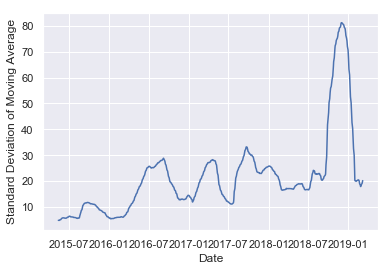

In [42]:
# Compute rolling standard deviation
std = pricing.rolling(90).std()

# Plot rolling std
_, ax2 = plt.subplots()
ax2.plot(std)
#ax2.set_xticklabels([pricing.index[i].date() for i in ticks[:-1]]) # Label x-axis with dates
plt.ylabel('Standard Deviation of Moving Average')
plt.xlabel('Date')

print ('Mean of rolling std:', np.mean(std))
print ('std of rolling std:', np.std(std))

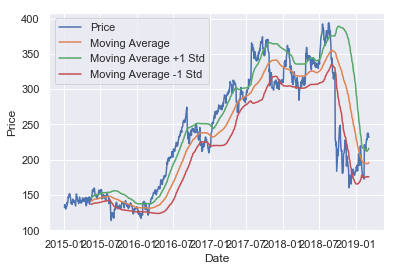

In [44]:
# Plot original data
_, ax3 = plt.subplots()
ax3.plot(pricing)
#ax3.set_xticklabels([pricing.index[i].date() for i in ticks[:-1]]) # Label x-axis with dates

# Plot Bollinger bands
ax3.plot(mu)
ax3.plot(mu + std)
ax3.plot(mu - std);
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend(['Price', 'Moving Average', 'Moving Average +1 Std', 'Moving Average -1 Std']);